# Creating phase diagram using trained model

In [1]:
import os
from pathlib import Path
import gc

import numpy as np
import matplotlib.pyplot as plt

import keras
import torch

from skyrmion_dataset import SKYRMION

os.environ["KERAS_BACKEND"] = "torch"

2025-03-11 18:58:16.671332: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-11 18:58:16.675878: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-11 18:58:16.731144: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-11 18:58:16.754454: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741715896.803218  107875 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741715896.81

In [2]:

model = keras.models.load_model("saved_models/model5-2025-02-20_112701-aug=c+m,dec=cosine,dro=0.keras", compile=False)


AttributeError: 'Namespace' object has no attribute 'fag'

In [3]:
dataset = np.load("data/train/datasetMC.npz")

In [ ]:

data_tensor = torch.Tensor(dataset["data"])

predictions = model.predict(data_tensor)

prediction_dataset = {
    "data": predictions,
    "values": dataset["values"]
}

In [5]:
def visualize_prediction_phase_diagram(dataset=prediction_dataset):
    fig, ax = plt.subplots(figsize=(11,8))

    r = dataset["data"][:, 0] # Ferromagnet
    g = dataset["data"][:, 1] # Skyrmion
    b = dataset["data"][:, 2] # Spiral

    colors = np.stack([r, b, g], axis=1)

    ax.scatter(*dataset["values"].T, c=(colors), marker="o", s=60)

    ax.set_title("Model phase diagram", size=16)
    ax.set_xlabel("D", size=16)
    ax.set_ylabel("B", size=16)

    plt.show()

In [4]:
data_subset = torch.Tensor(np.array(dataset["data"])[::5]).unsqueeze(-1)
values_subset = np.array(dataset["values"])[::5]

In [5]:
del dataset
gc.collect()

80

In [6]:
n_samples = 25
# torch.use_deterministic_algorithms(True)
model.set_mc_inference(True)

data_repeat = data_subset.repeat_interleave(n_samples, dim=0)
# Perform batched prediction
preds = model.predict(data_repeat).reshape(len(data_subset), n_samples, 3) # for mc_inference compute var across axis 1

1538/1538 ━━━━━━━━━━━━━━━━━━━━ 35s 23ms/step


In [17]:
del data_repeat
del data_subset
gc.collect()

362

In [20]:
variances = np.var(preds, axis=1).mean(axis=-1)

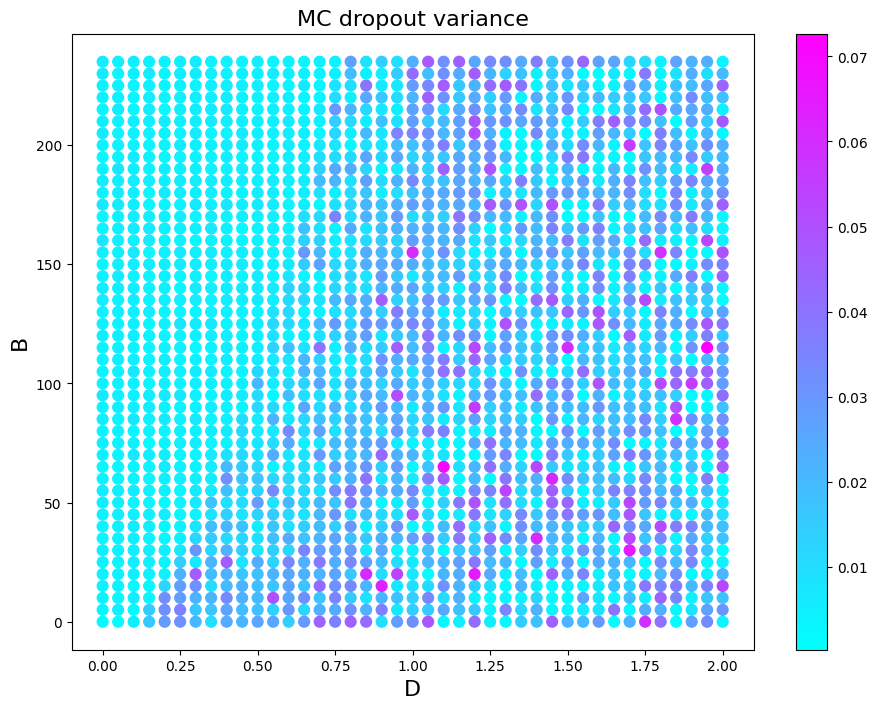

In [22]:
fig, ax = plt.subplots(figsize=(11,8))

m = ax.scatter(*values_subset.T, c=np.log2(variances), cmap="cool", marker="o", s=60)

ax.set_title("MC dropout variance", size=16)
ax.set_xlabel("D", size=16)
ax.set_ylabel("B", size=16)


cbar = fig.colorbar(m)

plt.show()

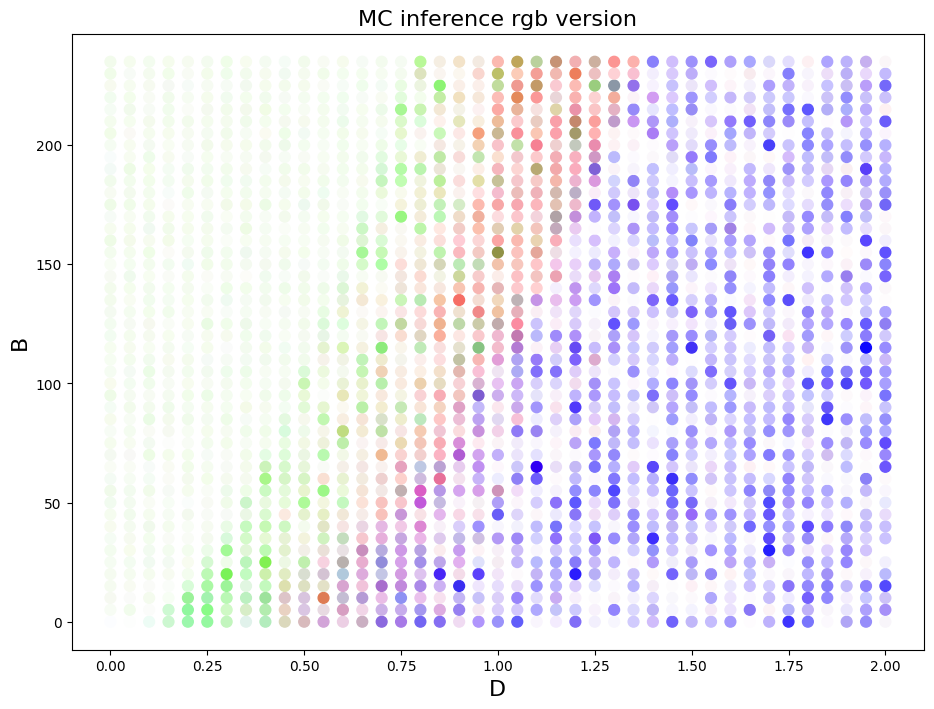

In [25]:
variances = np.var(preds, axis=1)

v_min = np.min(variances)
v_max = np.max(variances)

fig, ax = plt.subplots(figsize=(11,8))

r = 1 - (variances[:, 0] - v_min) / (v_max - v_min) # Ferromagnet
g = 1 - (variances[:, 1] - v_min) / (v_max - v_min) # Skyrmion
b = 1 - (variances[:, 2] - v_min) / (v_max - v_min) # Spiral

colors = np.stack([r, b, g], axis=1)

ax.scatter(*values_subset.T, c=(colors), marker="o", s=60)

ax.set_title("MC inference rgb version", size=16)
ax.set_xlabel("D", size=16)
ax.set_ylabel("B", size=16)

plt.show()

In [ ]:
def visualize_variance_phase_diagram(var_dict):
    fig, ax = plt.subplots(figsize=(11, 8))

    values = np.array(list(var_dict.keys())) 
    variances = np.array(list(var_dict.values()))

    norm = plt.Normalize(vmin=np.min(variances), vmax=np.max(variances))
    cmap = plt.cm.viridis

    sc = ax.scatter(values[:, 0], values[:, 1], c=variances, cmap=cmap, marker="o", s=60)

    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label("Variance", size=14)

    ax.set_title("Variance Phase Diagram", size=16)
    ax.set_xlabel("D", size=16)
    ax.set_ylabel("B", size=16)

    plt.show()

visualize_variance_phase_diagram(var_dict)